In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from qiskit_metal import designs
from qiskit_metal import draw, Dict
from qiskit_metal import MetalGUI, Dict
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
# for routing:
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.tlines.framed_path import RouteFramed
from qiskit_metal.qlibrary.core.qroute import QRouteLead, QRoutePoint, QRoute
from qiskit_metal.qlibrary.core import QComponent
# for jogs:
from collections import OrderedDict
import  math
import  numpy as np



In [3]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

design.variables['cpw_width'] = '10 um'
design.variables['cpw_gap'] = '6 um'

design.overwrite_enabled = True

In [13]:
pin_opt = Dict(pin_inputs=Dict(start_pin=Dict(
                                    component='open1i',
                                    pin='short'),
                                end_pin=Dict(
                                    component='open1o',
                                    pin='short')))

In [16]:
design.delete_all_components()  #needed only for rebuilds. will get a warning

otg11 = ShortToGround(design, 'open1i', options=Dict(pos_x='0 mm',  pos_y='1 mm', orientation='135'))
otg12 = ShortToGround(design, 'open1o', options=Dict(pos_x='1mm',  pos_y='0mm', orientation='0'))

gui.rebuild()
gui.autoscale()

In [111]:
# otg11.options.width = '5 um'
# otg11.options.gap = '3 um'
# np.concatenate([design.components['open1i'].pins['open'].points, design.components['open1o'].pins['open'].points])
# gui.rebuild()
# gui.autoscale()

array([[0.   , 1.005],
       [0.   , 0.995],
       [0.5  , 0.995],
       [0.5  , 1.005]])

In [18]:
route1 = RouteStraight(design, 'cpw_1', pin_opt)
# route1 = RoutePathfinder(design, 'cpw_1', pin_opt)
gui.rebuild()
gui.autoscale()

In [11]:
route1.options

{'chip': 'main',
 'layer': '1',
 'pin_inputs': {'start_pin': {'component': 'open1i', 'pin': 'open'},
  'end_pin': {'component': 'open1o', 'pin': 'open'}},
 'fillet': '0',
 'lead': {'start_straight': '0mm',
  'end_straight': '0mm',
  'start_jogged_extension': '',
  'end_jogged_extension': ''},
 'total_length': '7mm',
 'trace_width': 'cpw_width',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False,
 'trace_gap': 'cpw_gap',
 '_actual_length': '0.5 mm'}

In [106]:
route1.options.pin_inputs.start_pin

{'component': 'open1i', 'pin': 'open'}

In [99]:
gui.rebuild()
gui.autoscale()
gui.highlight_components(['open1i','open1o'])

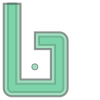

In [81]:
class MyFluxLine01(QComponent):
    """
   The flip chip flux line class

   Inherits the QComponent class

   flux line for the flip chip dev. Written for the flip chip tutorial.

   """
    default_options = Dict(pos_x='0 um',
                           pos_y='0 um',
                           l_1='8.5 um',
                           l_2='12 um',
                           l_3 = '28 um',
                           l_4 = '28 um',
                           l_5 = '50 um',
                           flux_cpw_width='5 um',
                           flux_cpw_gap='2.5 um',
                           # readout_cpw_turnradius='50 um',
                           # vertical_start_length = '40 um',
                           # vertical_end_length = '200 um',
                           # horizontal_start_length01= '400 um',
                           # horizontal_start_length02 = '400 um',
                           # horizontal_end_length = '500 um',
                           # total_length = '4000 um',
                           # arc_step='1 um',
                           # meander_round = '5',
                           orientation='0',
                           layer='1',
                           layer_subtract='2',
                           inverse = False,
                           mirror = False,
                           subtract=True,
                           chip='main',
                           _default_connection_pads=Dict())
    ''' Default drawing options ?? '''
    component_metadata = Dict(short_name='myfluxline01',
                              _qgeometry_table_poly='True',
                              _qgeometry_table_junction='False')
    ''' Component metadata '''

    def make(self):
        p = self.p

        w = p.flux_cpw_width
        g = p.flux_cpw_gap
        inverse = p.inverse
        mirror = p.mirror
        orientation = p.orientation
        pos_x = p.pos_x
        pos_y = p.pos_y
        pin = Dict(middle=np.array([w/2,-(p.l_3/2+p.l_1)]), normal=np.array([0,1]))
        pts_list = []
        z_line = QRouteLead()
        z_line.seed_from_pin(pin=pin)
        z_line.go_straight(p.l_1)
        pts_list.append(z_line.get_tip().position)

        z_line.go_right(p.l_2)
        pts_list.append(z_line.get_tip().position)

        z_line.go_left(p.l_3)
        pts_list.append(z_line.get_tip().position)

        z_line.go_left(p.l_4)
        pts_list.append(z_line.get_tip().position)

        z_line.go_left(p.l_5)
        pts_list.append(z_line.get_tip().position)

        line = draw.LineString(pts_list)
        line = line.buffer(w/2, cap_style=2, join_style=1)

        eps = 1e-3
        line = draw.Polygon(line.exterior)
        line = line.buffer(eps, join_style=2).buffer(-eps, join_style=2)

        pts_pin0 = pts_list[-1]-[w/2,0]
        pts_pin1 = pts_list[-1]+[w/2,0]
        pin_line = draw.LineString([pts_pin0,pts_pin1])
        line_etch = line.buffer(g, cap_style=2, join_style=2)

        x_s, y_s = pts_list[-1]-[0, g/2]
        subtract_patch = draw.LineString([(x_s- w / 2 - g - eps, y_s ),
                                              (x_s+ w / 2 + g + eps, y_s )
                                             ]).buffer(g / 2, cap_style=2)
        line_etch = line_etch.difference(subtract_patch)

        if (inverse==True):
             [line, line_etch, pin_line] = draw.shapely.transform( [line, line_etch, pin_line],lambda x: -x)
        if  (mirror==True):
             [line, line_etch, pin_line]= draw.shapely.transform( [line, line_etch, pin_line],lambda x: x*[-1,1])
        # rotate and translate
        polys = [line, line_etch, pin_line]
        polys = draw.rotate(polys, orientation, origin=(0, 0))
        polys = draw.translate(polys, pos_x, pos_y)


        # update each object
        [line, line_etch, pin_line] = polys

        # generate QGeometry
        self.add_qgeometry('poly', dict(line=line), chip=p.chip)
        self.add_qgeometry('poly',
                           dict(line_etch=line_etch),
                           chip=p.chip,
                           subtract=p.subtract)

        # generate pins
        self.add_pin('readout', pin_line.coords, width=w, gap=g, chip=p.chip)

    # draw.shapely.geometrycollections([line,pin_line,line_etch,draw.Point(0,0)])

# z_line.get_tip().position
# end_pin
# pin_opt = Dict(pin_inputs=Dict(start_pin=Dict(
#                                     component='open1i',
#                                     pin='open'), end_pin=Dict(
#                                     component='open1o',
#                                     pin='open')
#                                 ))
#
#
# pin_opt.lead.start_straight = '8.5 um'
# # pin_opt.lead.end_straight = '0.04mm'
#
# # any subsequent step of the lead_start
# jogsS = OrderedDict()
# jogsS[0] = ["R", '12um']
# jogsS[1] = ["L", '28um']
# jogsS[2] = ["L", '28um']
# jogsS[3] = ["L", '50um']
#
#
# # single jog on the lead_end, just for kicks
# # jogsE = OrderedDict()
# # jogsE[0] = ["L", '30um']
#
# pin_opt.lead.start_jogged_extension = jogsS
# # pin_opt.lead.end_jogged_extension = jogsE
#
#
# # z_line.length
#
# z_line0 = QRoute(design=design, name='zline', options=pin_opt )
# gui.rebuild()
# gui.autoscale()

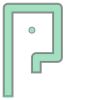

In [90]:
 w = 5
g = 2.5
inverse = False
mirror = False
orientation = 0
pos_x = 0.0
pos_y = 0.0
pin = Dict(middle=np.array([2.5,-24]), normal=np.array([0,1]))
pts_list = []

def  round_corner(radius,line):
    # line1 = line.buffer(1,cap_style=2)
    line1 = line.buffer(radius,join_style=1)
    line1 = line1.buffer(-2*radius, join_style=1)
    line1 = line1.buffer(radius,join_style=1)
    return  line1

z_line = QRouteLead()
z_line.seed_from_pin(pin=pin)
pts_list.append(np.array([2.5,-24]))
z_line.go_straight(8.5)
pts_list.append(z_line.get_tip().position)

z_line.go_right(12)
pts_list.append(z_line.get_tip().position)

z_line.go_left(28)
pts_list.append(z_line.get_tip().position)

z_line.go_left(28)
pts_list.append(z_line.get_tip().position)

z_line.go_left(50)
pts_list.append(z_line.get_tip().position)

line = draw.LineString(pts_list)
line = line.buffer(w/2, cap_style=2, join_style=1)

eps = 1e-2
# line = draw.Polygon(line.exterior)
# line = line.buffer(eps, join_style=2).buffer(-eps, join_style=2)

line = round_corner(eps,line)

pts_pin0 = pts_list[-1]-[w/2,0]
pts_pin1 = pts_list[-1]+[w/2,0]
pin_line = draw.LineString([pts_pin0,pts_pin1])
line_etch = line.buffer(g, cap_style=2, join_style=2)

x_s, y_s = pts_list[-1]-[0, g/2]
# subtract_patch = draw.LineString([(x_22, y_22 - w / 2 - g - eps),
#                                       (x_22, y_22 + w / 2 + g + eps)
#                                      ]).buffer(g / 2, cap_style=2)
subtract_patch = draw.LineString([(x_s- w / 2 - g - eps, y_s ),
                                      (x_s+ w / 2 + g + eps, y_s )
                                     ]).buffer(g / 2, cap_style=2)
line_etch = line_etch.difference(subtract_patch)

if (inverse==True):
     [line, line_etch, pin_line] = draw.shapely.transform( [line, line_etch, pin_line],lambda x: -x)
if  (mirror==True):
     [line, line_etch, pin_line]= draw.shapely.transform( [line, line_etch, pin_line],lambda x: x*[-1,1])
# # rotate and translate
# polys = [line, line_etch, pin_line]
# polys = draw.rotate(polys, orientation, origin=(0, 0))
# polys = draw.translate(polys, pos_x, pos_y)
#
#
# # update each object
# [ro, ro_etch, port_line] = polys

# generate QGeometry
# self.add_qgeometry('poly', dict(ro=ro), chip=chip, layer=p.layer)
# self.add_qgeometry('poly',
#                    dict(ro_etch=ro_etch),
#                    chip=chip,
#                    layer=p.layer_subtract,
#                    subtract=p.subtract)
#
# # generate pins
# self.add_pin('readout', port_line.coords, width=w, gap=g, chip=chip)

draw.shapely.geometrycollections([line,pin_line,draw.Point(0,0)])

In [42]:
w = 5
g = 3
w0 = 10
g0 = 6
inverse = False
mirror = False
orientation = 0
pos_x = 0.0
pos_y = 0.0
length1 = 200
length2 = 200
length3 = 20
angle = -45
c_length = 15
pin = Dict(middle=np.array([2.5,-24]), normal=np.array([0,1]))
pts_list = []

def  round_corner(radius,line):
    # line1 = line.buffer(1,cap_style=2)
    line1 = line.buffer(radius,join_style=1)
    line1 = line1.buffer(-2*radius, join_style=1)
    line1 = line1.buffer(radius,join_style=1)
    return  line1

z_line = QRouteLead()
z_line.seed_from_pin(pin=pin)
pts_list.append(np.array([2.5,-24]))
z_line.go_straight(8.5)
pts_list.append(z_line.get_tip().position)

z_line.go_right(12)
pts_list.append(z_line.get_tip().position)

z_line.go_left(28)
pts_list.append(z_line.get_tip().position)

z_line.go_left(28)
pts_list.append(z_line.get_tip().position)

z_line.go_left(50)
pts_list.append(z_line.get_tip().position)

z_line.go_angle(length1,angle)
pts_list.append(z_line.get_tip().position)

#determine four points for connector
x_0 = pts_list[-1]+w/2*np.array([math.cos(angle/180*math.pi),math.sin(angle/180*math.pi)])
x_1 = pts_list[-1]-w/2*np.array([math.cos(angle/180*math.pi),math.sin(angle/180*math.pi)])
x_m = pts_list[-1]+c_length*z_line.get_tip().direction
x_2 = x_m - w0/2*np.array([math.cos(angle/180*math.pi),math.sin(angle/180*math.pi)])
x_3 = x_m + w0/2*np.array([math.cos(angle/180*math.pi),math.sin(angle/180*math.pi)])
pts =[x_0,x_1,x_2,x_3]
connector =draw.Polygon(pts)

#draw second part
pin2 = Dict(middle=x_m, normal=z_line.get_tip().direction)
pts_list0 = []
z_line0 = QRouteLead()

z_line0.seed_from_pin(pin=pin2)
pts_list0.append(z_line0.get_tip().position)

z_line0.go_straight(length2)
pts_list0.append(z_line0.get_tip().position)

z_line0.go_angle(length3,angle)
pts_list0.append(z_line0.get_tip().position)

line = draw.LineString(pts_list)
line = line.buffer(w/2, cap_style=2, join_style=1)

line0 = draw.LineString(pts_list0)
line0 = line0.buffer(w0/2, cap_style=2, join_style=1)

eps = 1e-2
line = round_corner(eps,line)
line0 = round_corner(eps,line0)


# line = draw.Polygon(line.exterior)
# line = line.buffer(eps, join_style=2).buffer(-eps, join_style=2)



# pts_pin0 = pts_list[-1]-[w/2,0]
# pts_pin1 = pts_list[-1]+[w/2,0]
# pin_line = draw.LineString([pts_pin0,pts_pin1])
#draw connector etch
line_etch = line.buffer(g, cap_style=2, join_style=2)
line0_etch = line0.buffer(g0, cap_style=2, join_style=2)
x_0_etch = pts_list[-1]+(w/2+g)*np.array([math.cos(angle/180*math.pi),math.sin(angle/180*math.pi)])
x_1_etch = pts_list[-1]-(w/2+g)*np.array([math.cos(angle/180*math.pi),math.sin(angle/180*math.pi)])
x_2_etch = x_m - (w0/2+g0)*np.array([math.cos(angle/180*math.pi),math.sin(angle/180*math.pi)])
x_3_etch = x_m + (w0/2+g0)*np.array([math.cos(angle/180*math.pi),math.sin(angle/180*math.pi)])
pts_etch =[x_0_etch,x_1_etch,x_2_etch,x_3_etch]
connector_etch =draw.Polygon(pts_etch)

line = draw.unary_union([line,line0,connector])
line_etch = draw.unary_union([line_etch,line0_etch,connector_etch])
# x_s, y_s = pts_list[-1]-[0, g/2]
# # subtract_patch = draw.LineString([(x_22, y_22 - w / 2 - g - eps),
# #                                       (x_22, y_22 + w / 2 + g + eps)
# #                                      ]).buffer(g / 2, cap_style=2)
# subtract_patch = draw.LineString([(x_s- w / 2 - g - eps, y_s ),
#                                       (x_s+ w / 2 + g + eps, y_s )
#                                      ]).buffer(g / 2, cap_style=2)
# line_etch = line_etch.difference(subtract_patch)

if (inverse==True):
     [line, line_etch, pin_line] = draw.shapely.transform( [line, line_etch, pin_line],lambda x: -x)
if  (mirror==True):
     [line, line_etch, pin_line]= draw.shapely.transform( [line, line_etch, pin_line],lambda x: x*[-1,1])
# # rotate and translate
# polys = [line, line_etch, pin_line]
# polys = draw.rotate(polys, orientation, origin=(0, 0))
# polys = draw.translate(polys, pos_x, pos_y)
#
#
# # update each object
# [ro, ro_etch, port_line] = polys

# generate QGeometry
# self.add_qgeometry('poly', dict(ro=ro), chip=chip, layer=p.layer)
# self.add_qgeometry('poly',
#                    dict(ro_etch=ro_etch),
#                    chip=chip,
#                    layer=p.layer_subtract,
#                    subtract=p.subtract)
#
# # generate pins
# self.add_pin('readout', port_line.coords, width=w, gap=g, chip=chip)
pts_list0[-1][1]

# line
# draw.shapely.geometrycollections([line,line0,connector,line_etch,line0_etch,connector_etch])
# draw.shapely.geometrycollections([line,pin_line,draw.Poi
# nt(0,0)])

-330.9493141924172

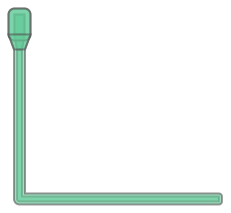

In [6]:
w = 5
g = 3
w0 = 10
g0 = 6
inverse = False
mirror = False
orientation = 0
pos_x = 0.0
pos_y = 0.0
l_1 = 200
l_2 = 150
l_3 = 20
angle = -90
c_length = 15
pin = Dict(middle=np.array([0,0]), normal=np.array([-1,0]))
pts_list = []

def  round_corner(radius,line):
    # line1 = line.buffer(1,cap_style=2)
    line1 = line.buffer(radius,join_style=1)
    line1 = line1.buffer(-2*radius, join_style=1)
    line1 = line1.buffer(radius,join_style=1)
    return  line1

z_line = QRouteLead()
z_line.seed_from_pin(pin=pin)
pts_list.append(np.array([0,0]))
z_line.go_straight(l_1)
pts_list.append(z_line.get_tip().position)

z_line.go_angle(l_2,angle)
pts_list.append(z_line.get_tip().position)

#determine four points for connector
x_0 = pts_list[-1]+w/2*np.array([math.sin(angle/180*math.pi),math.cos(angle/180*math.pi)])
x_1 = pts_list[-1]-w/2*np.array([math.sin(angle/180*math.pi),math.cos(angle/180*math.pi)])
x_m = pts_list[-1]+c_length*z_line.get_tip().direction
x_2 = x_m - w0/2*np.array([math.sin(angle/180*math.pi),math.cos(angle/180*math.pi)])
x_3 = x_m + w0/2*np.array([math.sin(angle/180*math.pi),math.cos(angle/180*math.pi)])
pts =[x_0,x_1,x_2,x_3]
connector =draw.Polygon(pts)

#draw second part
pin2 = Dict(middle=x_m, normal=z_line.get_tip().direction)
pts_list0 = []
z_line0 = QRouteLead()

z_line0.seed_from_pin(pin=pin2)
pts_list0.append(z_line0.get_tip().position)

z_line0.go_straight(l_3)
pts_list0.append(z_line0.get_tip().position)


line = draw.LineString(pts_list)
line = line.buffer(w/2, cap_style=2, join_style=1)

line0 = draw.LineString(pts_list0)
line0 = line0.buffer(w0/2, cap_style=2, join_style=1)

eps = 1e-2
line = round_corner(eps,line)
line0 = round_corner(eps,line0)


# line = draw.Polygon(line.exterior)
# line = line.buffer(eps, join_style=2).buffer(-eps, join_style=2)



# pts_pin0 = pts_list[-1]-[w/2,0]
# pts_pin1 = pts_list[-1]+[w/2,0]
# pin_line = draw.LineString([pts_pin0,pts_pin1])
#draw connector etch
line_etch = line.buffer(g, cap_style=2, join_style=2)
line0_etch = line0.buffer(g0, cap_style=2, join_style=2)
x_0_etch = pts_list[-1]+(w/2+g)*np.array([math.sin(angle/180*math.pi),math.cos(angle/180*math.pi)])
x_1_etch = pts_list[-1]-(w/2+g)*np.array([math.sin(angle/180*math.pi),math.cos(angle/180*math.pi)])
x_2_etch = x_m - (w0/2+g0)*np.array([math.sin(angle/180*math.pi),math.cos(angle/180*math.pi)])
x_3_etch = x_m + (w0/2+g0)*np.array([math.sin(angle/180*math.pi),math.cos(angle/180*math.pi)])
pts_etch =[x_0_etch,x_1_etch,x_2_etch,x_3_etch]
connector_etch =draw.Polygon(pts_etch)

line = draw.unary_union([line,line0,connector])
line_etch = draw.unary_union([line_etch,line0_etch,connector_etch])
# x_s, y_s = pts_list[-1]-[0, g/2]
# # subtract_patch = draw.LineString([(x_22, y_22 - w / 2 - g - eps),
# #                                       (x_22, y_22 + w / 2 + g + eps)
# #                                      ]).buffer(g / 2, cap_style=2)
# subtract_patch = draw.LineString([(x_s- w / 2 - g - eps, y_s ),
#                                       (x_s+ w / 2 + g + eps, y_s )
#                                      ]).buffer(g / 2, cap_style=2)
# line_etch = line_etch.difference(subtract_patch)

if (inverse==True):
     [line, line_etch, pin_line] = draw.shapely.transform( [line, line_etch, pin_line],lambda x: -x)
if  (mirror==True):
     [line, line_etch, pin_line]= draw.shapely.transform( [line, line_etch, pin_line],lambda x: x*[-1,1])
# # rotate and translate
# polys = [line, line_etch, pin_line]
# polys = draw.rotate(polys, orientation, origin=(0, 0))
# polys = draw.translate(polys, pos_x, pos_y)
#
#
# # update each object
# [ro, ro_etch, port_line] = polys

# generate QGeometry
# self.add_qgeometry('poly', dict(ro=ro), chip=chip, layer=p.layer)
# self.add_qgeometry('poly',
#                    dict(ro_etch=ro_etch),
#                    chip=chip,
#                    layer=p.layer_subtract,
#                    subtract=p.subtract)
#
# # generate pins
# self.add_pin('readout', port_line.coords, width=w, gap=g, chip=chip)
# pts_list0[-1][1]

# line
draw.shapely.geometrycollections([line,line0,connector,line_etch,line0_etch,connector_etch])
# draw.shapely.geometrycollections([line,pin_line,draw.Poi
# nt(0,0)])

In [ ]:
class MyReadoutRes01(QComponent):
    '''
    The base ReadoutResFC class

    Inherits the QComponent class

    Readout resonator for the flipchip dev. Written for the flipchip tutorial.

    The device consists of the following shapes combined together:
        - a circle centered at ('pos_x', 'pos_y') with a radius of 'readout_radius', followed by
        - a straight line (length= 'readout_l1') at a 45 degree angle, followed by
        - a 45 degree arc, followed by
        - a vertical line (length = 'readout_l2'), followed by
        - a 90 degree arc, followed by
        - a horizontal line (length = 'readout_l3'), followed by
        - a 180 degree arc, followed by
        - a horizontal line (length = 'readout_l4'), followed by
        - 5 meandering horizontal lines (length = 'readout_l5') separated 180 degree arcs.

    The arc has a bend radius of 'readout_cpw_turnradius',
        it is measured from the center of the cpw to the center of rotation.
    The lines and arcs will form a cpw with a signal linewidth of 'readout_cpw_width', and
        signal-to-ground separation of 'readout_cpw_gap'.

    One of the ways to adjust this design to your needs:
    - change the coupling to the qubit by varying the 'readout_radius',
    - couple the resonator to the feedthrough transmission line via
        the horizontal section with this length 'readout_l3',
    - adjust the frequency of the resonator by varying 'readout_l5'.

    '''

    default_options = Dict(pos_x='0 um',
                           pos_y='0 um',
                           readout_radius='50 um',
                           readout_cpw_width='5 um',
                           readout_cpw_gap='5 um',
                           readout_cpw_turnradius='50 um',
                           vertical_start_length = '40 um',
                           vertical_end_length = '200 um',
                           horizontal_start_length01= '400 um',
                           horizontal_start_length02 = '400 um',
                           horizontal_end_length = '500 um',
                           total_length = '4000 um',
                           arc_step='1 um',
                           meander_round = '5',
                           orientation='0',
                           layer='1',
                           layer_subtract='2',
                           inverse = False,
                           mirror = False,
                           subtract=True,
                           chip='main',
                           _default_connection_pads=Dict())
    ''' Default drawing options ?? '''
    component_metadata = Dict(short_name='myreadoutres01',
                              _qgeometry_table_poly='True',
                              _qgeometry_table_junction='False')
    ''' Component metadata '''

    ##########################
    def make(self):
        ''' Make the head for readout res'''
        self.make_ro()

    ##########################

    def make_ro(self):
        '''
        Create the head of the readout resonator.
        Contains: the circular patch for coupling,
            the 45 deg line,
            the 45 deg arc,
            a short straight segment (of length w) for smooth subtraction
        '''
        # access to parsed values from the user option
        p = self.p

        # access to chip name
        chip = p.chip

        # local variables
        r = p.readout_radius
        w = p.readout_cpw_width
        g = p.readout_cpw_gap
        turnradius = p.readout_cpw_turnradius
        N = p.meander_round
        l_1 = 0
        l_2 = p.vertical_start_length
        l_3 =  p. horizontal_start_length01
        l_4 = p.horizontal_start_length02

        total_length = p.total_length
        left_length = l_2+ p. vertical_end_length \
                       + l_3 + l_4 + p.horizontal_end_length + (N+2.5)*np.pi *turnradius
        if (total_length<=left_length):
            l_5 = 0
        l_5 =(total_length- left_length) / N
        l_6 = p.vertical_end_length
        l_7 = p.horizontal_end_length


        cparm_line = draw.unary_union(full_shape)
        cparm = cparm_line.buffer(w / 2, cap_style=2, join_style=1)


        ## fix the gap resulting from buffer
        eps = 1e-3
        cparm = draw.Polygon(cparm.exterior)
        cparm = cparm.buffer(eps, join_style=2).buffer(-eps, join_style=2)

        # create combined objects for the signal line and the etch
        ro = draw.unary_union([cppatch, cparm])
        ro_etch = ro.buffer(g, cap_style=2, join_style=2)
        # x_15, y_15 = x_14, y_14 + 7 * turnradius
        x_22, y_22 = x_21 + g / 2, y_21
        port_line = draw.LineString([(x_21, y_21 + w / 2),
                                     (x_21, y_21 - w / 2)])
        subtract_patch = draw.LineString([(x_22, y_22 - w / 2 - g - eps),
                                          (x_22, y_22 + w / 2 + g + eps)
                                         ]).buffer(g / 2, cap_style=2)
        ro_etch = ro_etch.difference(subtract_patch)

        #inverse and mirror
        [ro, ro_etch, port_line] = draw.shapely.transform( [ro, ro_etch, port_line],lambda x: -x)
        if (p.inverse==True):
             [ro, ro_etch, port_line] = draw.shapely.transform( [ro, ro_etch, port_line],lambda x: -x)
        if  (p.mirror==True):
             [ro, ro_etch, port_line]= draw.shapely.transform( [ro, ro_etch, port_line],lambda x: x*[-1,1])
        # rotate and translate
        polys = [ro, ro_etch, port_line]
        polys = draw.rotate(polys, p.orientation, origin=(0, 0))
        polys = draw.translate(polys, p.pos_x, p.pos_y)


        # update each object
        [ro, ro_etch, port_line] = polys

        # generate QGeometry
        self.add_qgeometry('poly', dict(ro=ro), chip=chip, layer=p.layer)
        self.add_qgeometry('poly',
                           dict(ro_etch=ro_etch),
                           chip=chip,
                           layer=p.layer_subtract,
                           subtract=p.subtract)

        # generate pins
        self.add_pin('readout', port_line.coords, width=w, gap=g, chip=chip)

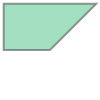

In [91]:
polygon = draw.Polygon([(0,0),(1,0),(2,1),(0,1)])
polygon